# Clustering the MNIST data set
Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy

from sklearn.cluster import KMeans

from src.optimal_transport import semi_discrete_ot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load dataset:

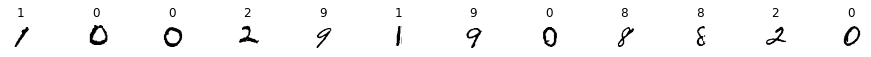

In [2]:
file = 'data/train-images.idx3-ubyte'
mnist_train_images = idx2numpy.convert_from_file(file)

file = 'data/train-labels.idx1-ubyte'
mnist_train_labels = idx2numpy.convert_from_file(file)


# visualize some digits
plt.figure(figsize=(16,0.5))
for i in range(12):
    plt.subplot(1, 12, i+1)
    idx = np.random.randint(mnist_train_images.shape[0])
    plt.imshow(mnist_train_images[idx], cmap='Greys')
    plt.title(mnist_train_labels[idx])
    plt.axis('off')

Convert images into point clouds:

/home/leonid_wasserstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


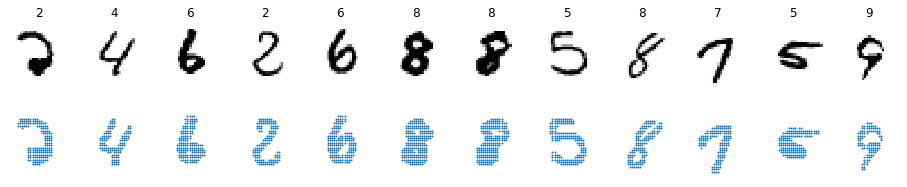

In [3]:
# image size
N = 28

# create point clouds and associated masses
point_clouds, masses = {}, {}
for i in range(len(mnist_train_images)):
    # extract support of point cloud
    idxes = np.where(mnist_train_images[i]>0)
    cloud = np.zeros((len(idxes[0]), 2))
    cloud[:, 0] = idxes[1]/N
    cloud[:, 1] = 1 - idxes[0]/N
    point_clouds[i] = cloud
    # extract masses of point cloud
    nu = mnist_train_images[i][np.where(mnist_train_images[i]>0)] + 1
    masses[i] = nu / np.sum(nu)
    
# visualize some point clouds
plt.figure(figsize=(16,3))
for i in range(12):
    plt.subplot(2, 12, i+1)
    idx = np.random.randint(mnist_train_images.shape[0])
    # show original image
    plt.imshow(mnist_train_images[idx], cmap='Greys')
    plt.title(mnist_train_labels[idx])
    plt.axis('off')
    plt.subplot(2, 12, 13+i)
    # show associated point cloud
    cloud = point_clouds[idx]
    plt.scatter(cloud[:, 0], cloud[:, 1], s=1)
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.axis('off')

Compute transport plans of each training image:

In [4]:
grid_size = 50
ot_mnist = semi_discrete_ot(grid_size=grid_size)
ot_mnist.fit_transport_plans(point_clouds, masses)

/home/leonid_wasserstein/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Perform K-Mean clustering on these transport plans:

In [5]:
n_clusters = 20

np.random.seed(2)

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10)
kmeans.fit(ot_mnist.transport_plans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Plot centroids:

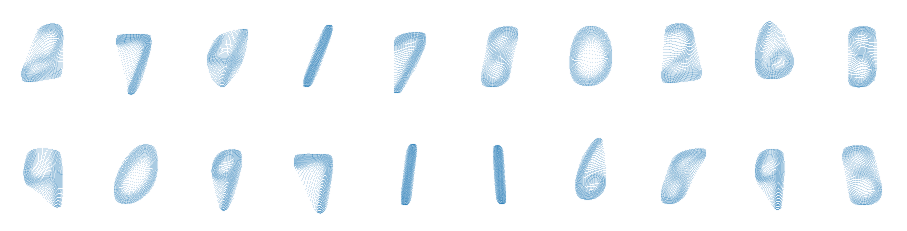

In [6]:
centroids = kmeans.cluster_centers_.reshape((n_clusters, -1, 2))

# plot centroids
plt.figure(figsize=(16,4))
for i in range(n_clusters):
    plt.subplot(2, 10, i+1)
    plt.scatter(centroids[i, :, 0], centroids[i, :, 1], s=0.005)
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.axis('off')